In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import datetime, os, wget, requests, unidecode, re
import uuid
import xlwings as xw
from lat_lon_parser import parse
from bs4 import BeautifulSoup

# Récupération des données

In [110]:
start_date = dt(2020, 11, 8)
end_date = dt(2021, 1, 26)
hours = ['14', '17', '21', '04', '08', '11']
last_day_hours = ['04', '08', '11', '14']

In [111]:
def download_excel(date, hour):
    str_date = date.strftime("%Y%m%d")
    url = f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_{str_date}_{hour}0000.xlsx'
    try:
        if not os.path.exists(f'vg_data/vendeeglobe_{str_date}_{hour}0000.xlsx'):
            wget.download(url, f'vg_data/vendeeglobe_{str_date}_{hour}0000.xlsx')
    except Exception as e:
        print(f'Error for {date.strftime("%Y-%m-%d")} at {hour}H:')
        print(e)

In [112]:
date = start_date
while date <= end_date:
    str_date = date.strftime("%Y%m%d")
    for hour in hours:
        download_excel(date, hour)
    date += datetime.timedelta(days=1)
for hour in last_day_hours:
    download_excel(date, hour)

Error for 2020-11-08 at 04H:
HTTP Error 404: Not Found
Error for 2020-11-08 at 08H:
HTTP Error 404: Not Found
Error for 2020-11-08 at 11H:
HTTP Error 404: Not Found


In [113]:
if os.path.exists(f'vg_data/vendeeglobe_20201108_140000.xlsx'):
        with xw.Book(f"vg_data/vendeeglobe_20201108_140000.xlsx", mode="r") as book:
            sheet1 = book.sheets[0]
            display(sheet1.cells.options("df").value.head(10))

,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
None,Classement du dimanche 08 novembre 2020 à 16h0...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
None,Rang\r\nRank,Nat. / Voile\r\nNat. / Sail,Skipper / Bateau\r\nSkipper / crew,None,None,None,Depuis 30 minutes\r\nSince 30 minutes,None,None,None,Depuis le dernier classement\r\nSince the the ...,None,None,None,Depuis 24 heures\r\nSince 24 hours,None,None,None,DTF,DTL
None,None,None,None,Heure FR\r\nHour FR,Latitude\r\nLatitude,Longitude\r\nLongitude,Cap\r\nHeading,Vitesse\r\nSpeed,VMG\r\nVMG,Distance\r\nDistance,Cap\r\nHeading,Vitesse\r\nSpeed,VMG\r\nVMG,Distance\r\nDistance,Cap\r\nHeading,Vitesse\r\nSpeed,VMG\r\nVMG,Distance\r\nDistance,None,None
None,1,\r\nFRA 18,Louis Burton\r\nBureau Vallée 2,15:30 FR\r\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,357°,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm
None,2,\r\nMON 10,Boris Herrmann\r\nSeaexplorer - Yacht Club De ...,15:31 FR\r\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,357°,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm
None,3,\r\nFRA 8,Jérémie Beyou\r\nCharal,15:30 FR\r\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,357°,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm
None,4,\r\nFRA 59,Thomas Ruyant\r\nLinkedOut,15:30 FR\r\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,0.7 nm,357°,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm
None,5,\r\nFRA 53,Maxime Sorel\r\nV And B Mayenne,15:30 FR\r\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,0.2 nm,357°,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm
None,6,\r\nFRA 56,Fabrice Amedeo\r\nNewrest - Art et Fenetres,15:31 FR\r\n1min,46°25.19'N,01°49.87'W,238°,16.9 kts,16.9 kts,0.6 nm,357°,0.0 kts,0.0 kts,2788.7 nm,200°,0.2 kts,0.2 kts,5.3 nm,24294.5 nm,0.7 nm


Les données sont très sales. Il faut bien définir les noms de colonnes, éliminer les \r\n, parser les nombres sans leur mesures

In [114]:
def clean_excel(date, hour):
    str_date = date.strftime("%Y%m%d")
    data = None
    if os.path.exists(f'vg_data/vendeeglobe_{str_date}_{hour}0000.xlsx'):
        with xw.Book(f"vg_data/vendeeglobe_{str_date}_{hour}0000.xlsx", mode="r") as book:
            sheet1 = book.sheets[0]
            data = sheet1.cells.options("df").value
        # création des noms de colonnes
        data = data.iloc[2:]
        data.iloc[1,:3] = data.iloc[0,:3]
        data.iloc[1,-2:] = data.iloc[0,-2:]
        data.iloc[1] = data.iloc[1].str.split("\r\n").str[0]
        data.iloc[1, 1] = data.iloc[1, 1].replace(" / ",' ')
        data.iloc[1, 2] = data.iloc[1, 2].replace(" / ",'\r\n')
        data.iloc[1,6:10] = data.iloc[1,6:10]+"_30m"
        data.iloc[1,10:14] = data.iloc[1,10:14]+"_last"
        data.iloc[1,14:18] = data.iloc[1,14:18]+"_24h"
        data.columns = data.iloc[1]
        data = data.iloc[2:]
        data = data.iloc[:-4]
        # Séparation des colonnes Nationalités et Voile
        nat_voile = "(?P<Nationalite>.*) (?P<Voile>[0-9]*)"
        data[["Nationalité", "Voile"]] = data['Nat. Voile'].str.extract(nat_voile, expand=True)
        # Séparation des colonnes Skipper et nom de bateau
        skipper_bateau = "(?P<Skipper>.*)\r\n(?P<nBateau>.*)"
        data[["Skipper", "Bateau"]] = data['Skipper\r\nBateau'].str.extract(skipper_bateau, expand=True)
        data = data.drop(['Nat. Voile', 'Skipper\r\nBateau'], axis=1)
        # Ajout de la date avec l'heure
        data["date"] = date + datetime.timedelta(hours=int(hour))
        data = data.reset_index(drop=True)
    return data

# Lambda pour extraire les nombres des strings (tous les chiffres sont accompagnés de leurs mesures)
get_num = lambda x: re.findall(r'-?\d+\.?\d*', x)[0] if len(re.findall(r'-?\d+\.?\d*', x)) > 0 else np.nan

In [115]:
# Creation du dataframe comportant toute les données de la course
date = start_date
race_df = pd.DataFrame()
while date <= end_date + datetime.timedelta(days=1):
    for hour in hours:
        tmp_df = clean_excel(date, hour)
        try :
            race_df = pd.concat([race_df, tmp_df])
        except Exception as e:
            print(e)
            break
    date += datetime.timedelta(days=1)
# Certains compétiteur ont abandonné la course, on supprime alors les lignes après leurs abandon (beaucoup de nan sur ces lignes)
race_df = race_df.dropna(subset=race_df.columns[1:18]).reset_index(drop=True)
# Standardisation des nom
race_df["Skipper"] = race_df["Skipper"].map(lambda x: unidecode.unidecode(x.lower()))
# Conversion de la latitude et longitude en format decimal
race_df['Latitude'] = race_df['Latitude'].apply(parse)
race_df['Longitude'] = race_df['Longitude'].apply(parse)

race_df['Rang'] = race_df['Rang'].astype(int)
# Extraction des nombres sans leur unité de mesure
race_df.iloc[:,4:-5] = race_df.iloc[:,4:-5].applymap(get_num).astype(float)
race_df = race_df.drop("Heure FR", axis=1)
race_df.head()

/tmp/ipykernel_5860/1026942527.py:23: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



,Rang,Latitude,Longitude,Cap_30m,Vitesse_30m,VMG_30m,Distance_30m,Cap_last,Vitesse_last,VMG_last,...,Vitesse_24h,VMG_24h,Distance_24h,DTF,DTL,Nationalité,Voile,Skipper,Bateau,date
0,1,46.407667,-1.841333,241.0,17.7,17.5,0.3,357.0,0.0,0.0,...,0.3,0.3,6.1,24293.9,0.0,FRA,18,louis burton,Bureau Vallée 2,2020-11-08 14:00:00
1,2,46.405667,-1.830333,241.0,11.1,10.9,0.4,357.0,0.0,0.0,...,0.3,0.2,6.0,24294.2,0.4,MON,10,boris herrmann,Seaexplorer - Yacht Club De Monaco,2020-11-08 14:00:00
2,3,46.415167,-1.833167,244.0,15.5,15.5,0.5,357.0,0.0,0.0,...,0.2,0.2,5.5,24294.3,0.5,FRA,8,jeremie beyou,Charal,2020-11-08 14:00:00
3,4,46.411833,-1.828000,244.0,13.2,13.1,0.7,357.0,0.0,0.0,...,0.2,0.2,5.6,24294.5,0.6,FRA,59,thomas ruyant,LinkedOut,2020-11-08 14:00:00
4,5,46.409833,-1.826000,246.0,10.9,10.9,0.2,357.0,0.0,0.0,...,0.8,0.7,5.8,24294.5,0.6,FRA,53,maxime sorel,V And B Mayenne,2020-11-08 14:00:00


In [116]:
race_df.describe()

,Rang,Latitude,Longitude,Cap_30m,Vitesse_30m,VMG_30m,Distance_30m,Cap_last,Vitesse_last,VMG_last,Distance_last,Cap_24h,Vitesse_24h,VMG_24h,Distance_24h,DTF,DTL
count,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000,13671.000000
mean,14.843245,-23.994974,-9.547301,131.921732,13.183695,11.375869,6.585378,131.179870,12.913591,11.398713,57.898639,126.844342,12.354656,11.264750,296.424556,14221.276234,1569.836179
std,8.432490,32.572373,77.434070,81.386355,3.968097,4.672140,2.079218,81.261142,3.885437,4.362511,134.437339,78.173102,3.482945,3.672004,83.742461,6729.476133,1544.280590
min,1.000000,-58.923000,-179.988500,0.000000,0.000000,-12.200000,0.000000,0.000000,0.000000,-8.600000,0.000000,0.000000,0.000000,-6.000000,0.000000,80.500000,0.000000
25%,8.000000,-48.737750,-35.152000,80.000000,10.800000,8.600000,5.400000,80.000000,10.600000,8.800000,36.400000,80.000000,10.200000,8.900000,244.800000,8509.750000,315.600000
50%,15.000000,-40.122833,-26.675667,108.000000,13.400000,11.800000,6.700000,106.000000,13.200000,11.700000,47.000000,100.000000,12.600000,11.500000,301.600000,14740.600000,893.400000
75%,22.000000,-0.330917,23.980417,182.000000,16.000000,14.800000,8.000000,182.000000,15.700000,14.600000,60.500000,182.000000,14.800000,13.900000,356.000000,20199.100000,2694.450000
max,33.000000,47.889500,179.949333,360.000000,24.300000,24.100000,32.500000,360.000000,23.900000,23.300000,2795.500000,360.000000,21.500000,21.300000,515.300000,24298.400000,8078.400000


In [117]:
race_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13671 entries, 0 to 13670
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Rang           13671 non-null  int64         
 1   Latitude       13671 non-null  float64       
 2   Longitude      13671 non-null  float64       
 3   Cap_30m        13671 non-null  float64       
 4   Vitesse_30m    13671 non-null  float64       
 5   VMG_30m        13671 non-null  float64       
 6   Distance_30m   13671 non-null  float64       
 7   Cap_last       13671 non-null  float64       
 8   Vitesse_last   13671 non-null  float64       
 9   VMG_last       13671 non-null  float64       
 10  Distance_last  13671 non-null  float64       
 11  Cap_24h        13671 non-null  float64       
 12  Vitesse_24h    13671 non-null  float64       
 13  VMG_24h        13671 non-null  float64       
 14  Distance_24h   13671 non-null  float64       
 15  DTF            1367

# Récuperation des caracteristiques des bateaux

In [118]:
url = "https://www.vendeeglobe.org/fr/glossaire"
page = requests.get(url).content
soup = BeautifulSoup(page)

In [119]:
specs_ul = soup.find_all('ul', {"class","boats-list__popup-specs-list"})

In [120]:
dict_list = []
for spec_ul in specs_ul:
    specs_list = [elem.string.split(' : ') for elem in spec_ul.find_all('li')]
    specs_dict = {elem[0]: elem[1] for elem in specs_list}
    # Le nom est disponibe dans un lien parents de la liste menant vers la fiche skipper. Ce lien contient son nom a la fin
    skipper = spec_ul.parent()[0].parent()[-5]['href'].split('/')[-1].replace('-', ' ')
    specs_dict["Skipper"] = skipper
    dict_list.append(specs_dict)
specs_df = pd.DataFrame(dict_list).drop(16).set_index("Skipper")
specs_df.head()

,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
Skipper,,,,,,,,,,,,,,
fabrice amedeo,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
romain attanasio,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
alexia barrier,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
yannick bestaven,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
jeremie beyou,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2


Il était prévu à l'origine de faire le lien entre les specs et les bateaux par leur numero de voile. Malheureusement, ces derniers ne correspondent pas toujours. Il a donc été choisis de scraper le nom du skipper associé au bateau pour faire le lien avec les données de courses.

In [143]:
# Extraction des nombres sans leurs mesures
numerical_specs = specs_df.iloc[:, [5,6,7,8,10,12,13]].stack().str.replace(',','.').apply(get_num).unstack()
numerical_specs.head()

,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant
Skipper,,,,,,,
fabrice amedeo,18.28,5.85,4.50,7,29,320,570
romain attanasio,18.28,5.80,4.50,9,28,280,560
alexia barrier,18.28,5.54,4.50,9,29,260,580
yannick bestaven,18.28,5.80,4.50,8,29,310,550
jeremie beyou,18.28,5.85,4.50,8,29,320,600


NaN values, on utilise un knn pour inferer leur valeur.

In [122]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
numerical_specs = pd.DataFrame(imputer.fit_transform(numerical_specs), columns=numerical_specs.columns, index=numerical_specs.index, dtype=float)
numerical_specs

,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant
Skipper,,,,,,,
fabrice amedeo,18.28,5.85,4.5,7.00,29.0,320.0,570.0
romain attanasio,18.28,5.80,4.5,9.00,28.0,280.0,560.0
alexia barrier,18.28,5.54,4.5,9.00,29.0,260.0,580.0
yannick bestaven,18.28,5.80,4.5,8.00,29.0,310.0,550.0
jeremie beyou,18.28,5.85,4.5,8.00,29.0,320.0,600.0
arnaud boissieres,18.28,5.65,4.5,7.90,29.0,300.0,610.0
louis burton,18.28,5.80,4.5,7.60,28.0,300.0,600.0
didac costa,18.28,5.30,4.5,8.90,26.0,240.0,470.0
manuel cousin,18.28,5.80,4.5,9.00,28.5,270.0,560.0


In [123]:
clean_specs_df = specs_df.copy()
clean_specs_df.iloc[:, [5,6,7,8,10,12,13]] = numerical_specs
# Le nombre de dérives est soit 2 soit foil. On choisit donc de la rendre booleen en fonction de la présence ou nom d'un foil
clean_specs_df['Nombre de dérives'] = clean_specs_df['Nombre de dérives'].str.contains('foil')
clean_specs_df.rename(columns={"Nombre de dérives": "Foil"}, inplace=True)
clean_specs_df = clean_specs_df.drop(clean_specs_df.columns[[0,1]], axis = 1)
clean_specs_df.head()

,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Foil,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
Skipper,,,,,,,,,,,,
fabrice amedeo,VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.5,7.0,True,29.0,monotype,320.0,570.0
romain attanasio,Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.8,4.5,9.0,False,28.0,acier forgé,280.0,560.0
alexia barrier,Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.5,9.0,False,29.0,acier,260.0,580.0
yannick bestaven,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.8,4.5,8.0,True,29.0,acier mécano soudé,310.0,550.0
jeremie beyou,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.5,8.0,True,29.0,acier,320.0,600.0


# Visiualisations

## Course

Dans cette partie, nous allons visualiser, sur une carte, le trajet des k premiers compétiteurs. Cette carte est intéractive et permet de choisir l'avancée des compétiteurs en fonction de la date.

In [124]:
from ipywidgets import widgets
from ipyleaflet import Map, AntPath, WidgetControl, LegendControl
import seaborn as sns


In [125]:
def get_skipper_loc(race, name, until=None):
    locations = race.loc[race['Skipper'] == name]
    if until == None:
        return locations[['Latitude', 'Longitude']].values.tolist()
    return locations.loc[locations['date'] <= until, ['Latitude', 'Longitude']].values.tolist()

def get_top_k_skipper_race(race, k):
    top_k_skippers = race.sort_values(by=['date', 'Rang'], ascending=[False, True]).head(k)['Skipper'].unique()
    ordered_top_k_race = race.loc[race['Skipper'].isin(top_k_skippers)].sort_values(by=['Skipper', 'date'])
    return top_k_skippers, ordered_top_k_race

In [126]:
nb_skipper = 6

main_palette = sns.color_palette("hls", nb_skipper, desat=0.7).as_hex()
dot_palette = sns.color_palette("hls", nb_skipper).as_hex()

top_k_skippers, ordered_top_k_race = get_top_k_skipper_race(race_df, nb_skipper)

ant_paths = {skipper : AntPath(
    locations=get_skipper_loc(ordered_top_k_race, skipper),
    dash_array=[1, 10],
    delay=1000,
    color=color,
    pulse_color=pulse_color
) for skipper, color, pulse_color in zip(top_k_skippers[:nb_skipper], main_palette[:nb_skipper], dot_palette[:nb_skipper])}

def on_value_change(change):
    new_date = change['new']
    for skipper, ant_path in ant_paths.items():
        ant_path.locations = get_skipper_loc(ordered_top_k_race, skipper, new_date)

days = [dt.fromordinal(i) for i in range(start_date.toordinal(), (end_date + datetime.timedelta(days=2)).toordinal())]

date_slider = widgets.SelectionSlider(
    options=days,
    description='Date',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
date_slider.observe(on_value_change, names='value')

In [127]:
m = Map(center=(-10.407666666666664, -1.8413333333333333), zoom=2)
for ant_path in ant_paths.values():
    m.add_layer(ant_path)

widget_control1 = WidgetControl(widget=date_slider, position='topleft')
m.add_control(widget_control1)

legend = LegendControl({skipper: color for skipper, color in zip(top_k_skippers, main_palette)}, name="Skipper", position="topright")
m.add_control(legend)
m

Map(center=[-10.407666666666664, -1.8413333333333333], controls=(ZoomControl(options=['position', 'zoom_in_tex…

In [142]:
# Décommenter et exécuter pour fermer la carte intéractive ci dessus
m.close()

## Classement

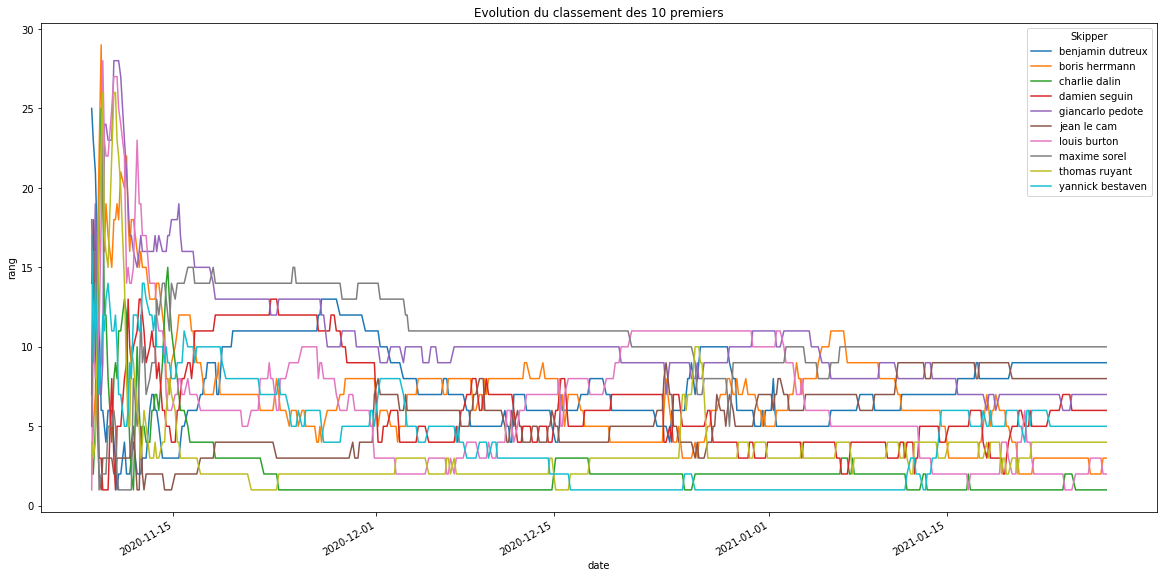

In [129]:
top_10_skipper, top_10_race = get_top_k_skipper_race(race_df, 10)
grouped_race = top_10_race.pivot_table(values='Rang', index='date', columns='Skipper')
grouped_race.plot(figsize=(20, 10), ylabel='rang', title="Evolution du classement des 10 premiers")
plt.show()

Le classement bouge beaucoup les premiers jours mais se stabilise assez rapidement. On remarque qu'il y a eu tout de même une bagarre assez constante entre la 5ème et la 10ème places. Les skippers devaient être assez rapproché à ce niveau de la course.

In [130]:
import plotly.express as px
full_race = pd.merge(race_df, clean_specs_df, on="Skipper")

distance_table = full_race.pivot_table(values="Distance_last", index="date", columns = "Skipper").iloc[3:].cumsum()
fig = px.line(distance_table, title="Distance parcourue par compétiteur", labels={"value": "Distance parcourue (nm)"}, height=800) 
fig.show()

On observe bien l'écart de distance parcourue. Le premier de la course avait 1 mois d'avances par rapport au dernier.

## Impact des caracteristiques du bateau dans la course

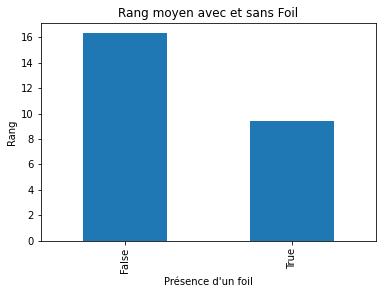

In [131]:
k = 25
full_top_k_race = full_race.sort_values(by=['date', 'Rang'], ascending=[False, True]).head(k)
mean_rank = full_top_k_race.groupby("Foil")['Rang'].mean()
mean_rank.plot.bar(ylabel='Rang', xlabel="Présence d'un foil", title='Rang moyen avec et sans Foil')
plt.show()

On remarque clairement l'impact du foil dans la cours. Un compétiteur avec foil fini en moyenne 5 places devant un compétiteur sans foil

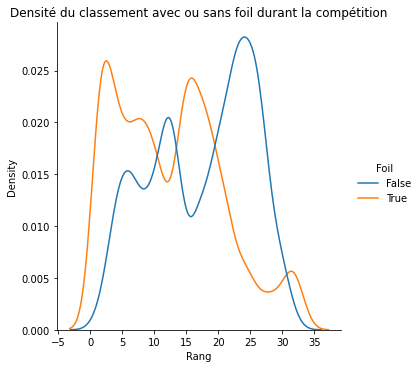

In [132]:
sns.displot(full_race[["Rang", "Foil"]], x="Rang", hue="Foil", kind='kde')
plt.title("Densité du classement avec ou sans foil durant la compétition")
plt.show()

Autre visualisation permettant d'illustrer l'impact du foil dans la compétition. On voit bien le pic de densité sans foil entre la 25 - 30ème place tandis que la densité avec foil domine les 10 premieres places du classement.

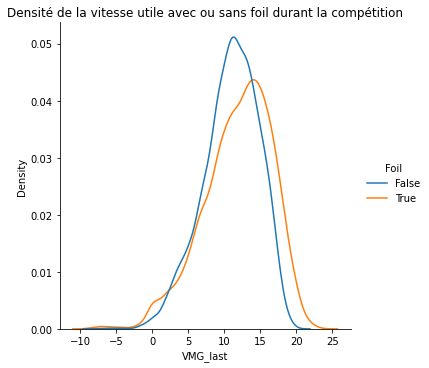

In [133]:
sns.displot(full_race[["VMG_last", "Foil"]], x="VMG_last", hue="Foil", kind='kde')
plt.title("Densité de la vitesse utile avec ou sans foil durant la compétition")
plt.show()

On observe aussi que le foil impact positivement la vitesse utile des compétiteurs

In [141]:
moy_vmg = race_df.groupby("Skipper")["VMG_last"].mean().sort_values(ascending=False)
numerical_specs["VMG_moy"] = moy_vmg
corr_matrix = numerical_specs.drop(columns=["Longueur", "Tirant d'eau"]).corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,Largeur,Déplacement (poids),Hauteur mât,Surface de voiles au près,Surface de voiles au portant,VMG_moy
Largeur,1.000000,-0.022609,0.309948,0.233622,0.036731,0.157430
Déplacement (poids),-0.022609,1.000000,-0.207137,-0.419710,-0.178917,-0.310454
Hauteur mât,0.309948,-0.207137,1.000000,0.436108,0.323482,0.036685
Surface de voiles au près,0.233622,-0.419710,0.436108,1.000000,0.329168,0.447587
Surface de voiles au portant,0.036731,-0.178917,0.323482,0.329168,1.000000,0.041802
VMG_moy,0.157430,-0.310454,0.036685,0.447587,0.041802,1.000000


Après une petite étude de la correlation des specs des bateaux par rapport à la vitesse moyenne, il semble que la caracteristique la plus impactante est la surface de voiles au près. Les autres caractéristiques semblent très peu corrélées.